In [1]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
import os
import sys
import pandas as pd
from pandas_plink import read_plink1_bin, Chunk
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize

In [2]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [3]:
chrom = 1

In [4]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/sample_mapping_file.tsv"
sample_mapping = pd.read_csv(sample_mapping_file, sep='\t', dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [5]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [6]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
# G = read_plink1_bin(plink_file, chunk=Chunk(nsamples=10, nvariants=3))
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:17<00:00, 125.72s/it]


In [7]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [8]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [9]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)
del K

In [10]:
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 36044
Sample mapping number of rows AFTER intersection: 35751


In [11]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [12]:
# environments
# cells by MOFA factors (10)
# E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/mofa_logcounts_model_factors.csv"
# cells by PCs (500)
E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/pcs_500hvgs.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [13]:
# subselect to only SNPs on right chromosome
G_sel = G.where(G.chrom == str(chrom), drop=True)

In [14]:
G_sel

<xarray.DataArray 'genotype' (sample: 1610, variant: 796303)>
dask.array<where, shape=(1610, 796303), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
  * variant  (variant) object '1_1_662622_G_A' ... '1_1_249230318_A_G'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '1' '1' '1' '1' '1' '1' ... '1' '1' '1' '1' '1'
    snp      (variant) object '1_662622_G_A' ... '1_249230318_A_G'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 662622 693731 706645 ... 249230279 249230318
    a0       (variant) object 'G' 'A' 'A' 'A' 'C' 'G' ... 'G' 'T' 'T' 'C' 'A'
    a1       (variant) object 'A' 'G' 'C' 'G' 'T' 'A' ... 'A' 'A' 'C' 'G' 'G'

In [15]:
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2542 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [16]:
n_factors = 10
E = E.values[:,0:n_factors]

In [17]:
# get eigendecomposition of EEt
[U, S, _] = economic_svd(E)
us = U * S
# get decomposition of K*EEt
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]

In [18]:
Ls[1].shape

(35751, 125)

In [19]:
# Phenotype
phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.tsv.pkl"
phenotype = pd.read_pickle(phenotype_file)
phenotype

,21843_1#10,21843_1#100,21843_1#101,21843_1#102,21843_1#103,21843_1#105,21843_1#106,21843_1#107,21843_1#108,21843_1#109,...,24539_8#88,24539_8#89,24539_8#90,24539_8#91,24539_8#92,24539_8#93,24539_8#94,24539_8#95,24539_8#97,24539_8#98
ENSG00000000003_TSPAN6,5.520777,6.456208,5.878671,4.860824,5.903640,4.513537,6.401983,5.909216,5.366645,3.228852,...,5.841814,6.104105,6.275649,7.029407,5.806978,6.199875,7.014180,6.228476,6.217161,6.034232
ENSG00000000419_DPM1,5.392461,6.065923,6.838769,6.614268,6.512403,5.527439,6.525591,6.381135,6.157296,6.248478,...,6.543807,6.369119,7.185421,6.337047,6.162437,5.885993,7.431358,7.013124,4.851771,4.937248
ENSG00000000457_SCYL3,0.000174,0.352597,0.000000,0.825955,2.201697,0.262446,0.000000,1.506837,0.283516,3.241977,...,0.017386,0.949668,0.035526,0.032044,1.773369,0.000000,0.108025,1.756339,2.492943,1.363441
ENSG00000000460_C1orf112,1.471928,4.536968,4.318528,5.373009,4.636175,4.225468,0.409785,3.668277,3.057933,3.154891,...,4.720967,3.791536,2.696476,4.227515,4.243689,3.227508,2.621121,3.950978,3.926914,4.211904
ENSG00000001036_FUCA2,2.908802,3.867327,3.321747,3.736476,4.917576,2.456866,0.577839,4.777404,2.873857,2.536708,...,3.070608,4.491643,4.206249,3.695005,2.652845,4.221847,3.188030,4.741496,3.872743,4.374577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000271043_MTRNR2L2,8.993125,10.310311,10.112632,9.380978,9.511378,7.531314,9.565223,9.659486,7.748536,10.087547,...,5.273407,5.649628,5.465876,5.388675,5.636233,1.709041,7.568684,6.345048,7.577899,7.012576
ENSG00000271303_SRXN1,0.000000,0.000000,0.390075,0.000000,0.000000,0.000000,0.000000,0.000000,2.388986,0.000000,...,0.000000,3.061808,1.707139,0.000000,2.637493,0.000000,0.000000,0.284224,0.000000,0.000000
ENSG00000272047_GTF2H5,1.397666,1.399811,2.421133,2.250520,2.633359,2.078498,1.513069,2.972922,2.012249,1.675936,...,2.316120,2.299498,2.392277,1.653269,2.254969,3.208027,4.137374,1.847985,2.144427,2.105545
ENSG00000272325_NUDT3,0.716015,1.857059,2.499615,2.615108,1.682406,2.295494,2.040256,1.896238,1.236113,1.544098,...,1.210306,0.538546,1.002614,1.901335,1.037860,2.139444,0.852408,1.091890,2.796956,2.493385


In [20]:
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 36044)
Phenotype shape AFTER selection: (11231, 35751)


In [21]:
phenotype

<xarray.DataArray (trait: 11231, cell: 35751)>
array([[5.52077706e+00, 6.45620778e+00, 5.87867097e+00, ...,
        6.22847584e+00, 6.21716111e+00, 6.03423233e+00],
       [5.39246051e+00, 6.06592255e+00, 6.83876922e+00, ...,
        7.01312448e+00, 4.85177110e+00, 4.93724790e+00],
       [1.74155604e-04, 3.52596612e-01, 0.00000000e+00, ...,
        1.75633852e+00, 2.49294278e+00, 1.36344116e+00],
       ...,
       [1.39766627e+00, 1.39981065e+00, 2.42113299e+00, ...,
        1.84798489e+00, 2.14442714e+00, 2.10554501e+00],
       [7.16014880e-01, 1.85705932e+00, 2.49961503e+00, ...,
        1.09189033e+00, 2.79695639e+00, 2.49338533e+00],
       [2.57831281e+00, 0.00000000e+00, 8.89010394e-01, ...,
        7.10952922e+00, 7.18506822e+00, 6.75613759e+00]])
Coordinates:
  * trait    (trait) object 'ENSG00000000003_TSPAN6' ... 'ENSG00000272398_CD24'
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '24539_8#98'

In [22]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/eqtl_allstages.tsv"
endo_eqtl = pd.read_csv(endo_eqtl_file, sep="\t", index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()
# genes

In [23]:
len(genes)

315

In [24]:
# Set up model
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [57]:
i = 2
trait_name = genes[i]
# trait_name = "ENSG00000111671_SPSB2"
trait_name

'ENSG00000137944_CCBL2'

In [58]:
y = phenotype.sel(trait=trait_name)
y = quantile_gaussianize(y)
E = quantile_gaussianize(E)

In [59]:
y = np.asarray(y)

In [60]:
slmm2 = StructLMM2(y, M, E, Ls)

In [61]:
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
G_tmp.shape

(35751, 2)

In [62]:
G_maf = G_sel[G_sel['sample'].isin(donors),G_sel['snp'].isin(leads)]
G_maf

<xarray.DataArray 'genotype' (sample: 125, variant: 2)>
dask.array<getitem, shape=(125, 2), dtype=float32, chunksize=(108, 2), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'HPSI0115i-zihe_1' ... 'HPSI0414i-tout_1'
  * variant  (variant) object '1_1_89373371_T_C' '1_1_89447978_T_A'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object 'HPSI0115i-zihe_1' ... 'HPSI0414i-tout_1'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '1' '1'
    snp      (variant) object '1_89373371_T_C' '1_89447978_T_A'
    cm       (variant) float64 0.0 0.0
    pos      (variant) int32 89373371 89447978
    a0       (variant) object 'T' 'T'
    a1       (variant) object 'C' 'A'

In [63]:
from __future__ import division
def compute_maf(X):
    r"""Compute minor allele frequencies.
    It assumes that ``X`` encodes 0, 1, and 2 representing the number
    of alleles (or dosage), or ``NaN`` to represent missing values.
    Parameters
    ----------
    X : array_like
        Genotype matrix.
    Returns
    -------
    array_like
        Minor allele frequencies.
    Examples
    --------
    .. doctest::
        >>> from numpy.random import RandomState
        >>> from limix.qc import compute_maf
        >>>
        >>> random = RandomState(0)
        >>> X = random.randint(0, 3, size=(100, 10))
        >>>
        >>> print(compute_maf(X)) # doctest: +FLOAT_CMP
        [0.49  0.49  0.445 0.495 0.5   0.45  0.48  0.48  0.47  0.435]
    """
    import dask.array as da
    import xarray as xr
    from pandas import DataFrame
    from numpy import isnan, logical_not, minimum, nansum
    if isinstance(X, da.Array):
        s0 = da.nansum(X, axis=0).compute()
        denom = 2 * (X.shape[0] - da.isnan(X).sum(axis=0)).compute()
    elif isinstance(X, DataFrame):
        s0 = X.sum(axis=0, skipna=True)
        denom = 2 * logical_not(X.isna()).sum(axis=0)
    elif isinstance(X, xr.DataArray):
        if "sample" in X.dims:
            kwargs = {"dim": "sample"}
        else:
            kwargs = {"axis": 0}
        s0 = X.sum(skipna=True, **kwargs)
        denom = 2 * logical_not(isnan(X)).sum(**kwargs)
    else:
        s0 = nansum(X, axis=0)
        denom = 2 * logical_not(isnan(X)).sum(axis=0)
    s0 = s0 / denom
    s1 = 1 - s0
    maf = minimum(s0, s1)
    if hasattr(maf, "name"):
        maf.name = "maf"
    return maf

In [64]:
mafs = compute_maf(G_maf).compute()

In [65]:
mafs

<xarray.DataArray 'maf' (variant: 2)>
array([0.444, 0.432])
Coordinates:
  * variant  (variant) object '1_1_89373371_T_C' '1_1_89447978_T_A'
    chrom    (variant) object '1' '1'
    snp      (variant) object '1_89373371_T_C' '1_89447978_T_A'
    cm       (variant) float64 0.0 0.0
    pos      (variant) int32 89373371 89447978
    a0       (variant) object 'T' 'T'
    a1       (variant) object 'C' 'A'

In [66]:
b = slmm2.predict_interaction(G_tmp, mafs)

In [67]:
# beta_G value for each of the SNPs tested
beta_G = b[0]
beta_G.shape

(2,)

In [68]:
# beta_GxE values (should be n_cells x nSNPs)
beta_GxE = b[1][0]
beta_GxE.shape

(35751, 2)

In [ ]:
# save

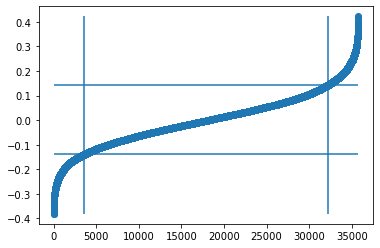

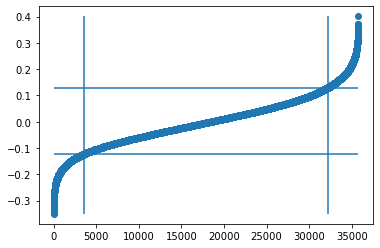

In [69]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
##
beta = np.array([])
for i in range(beta_GxE.shape[1]):
# for i in range(5):
    # get single-cell effect sizes
    v = beta_GxE[:,i] 
    # get min and max
    ymin = min(v)
    ymax = max(v)
    # rank values
    order = v.argsort()
    y = v[order]
    x = range(len(v))
    plt.scatter(x,y)
    # define 10% of cells
    xx = ceil(0.1*len(v))
    plt.vlines(x=xx,ymin=ymin, ymax=ymax)
    plt.hlines(y=y[xx],xmin=0, xmax=len(v))
    plt.vlines(x=len(v)-xx,ymin=ymin, ymax=ymax)
    plt.hlines(y=y[len(v)-xx],xmin=0, xmax=len(v))
    # add title
#     plt.title(df.columns.values[i])
#     plt.title(str(i))
    plt.show()
    beta = np.append(beta,y[len(v)-xx]-y[xx])

In [70]:
beta

array([0.28185961, 0.25155123])

In [56]:
beta

array([0.24156993])

In [39]:
beta

array([0.4649569])